In [1]:
import torch
import pickle
import gzip
import matplotlib.pyplot as plt
from torch import nn
import numpy as np

In [2]:
file = gzip.open("mnist.pkl.gz")
((x_train, y_train), (x_valid, y_valid), _ )=pickle.load(file, encoding='latin-1')

In [11]:
x_train = torch.tensor(x_train, dtype=torch.float)
x_test = torch.tensor(x_valid, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test= torch.tensor(y_valid, dtype=torch.long)

/tmp/ipykernel_1435/1774823716.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float)
/tmp/ipykernel_1435/1774823716.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)


In [4]:
28*28

784

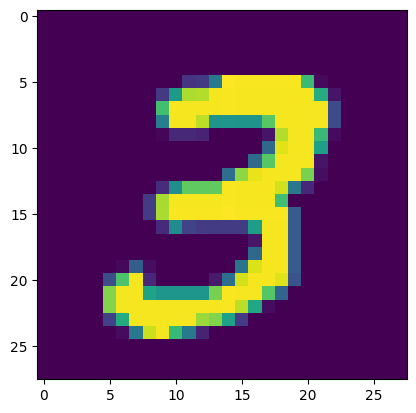

In [5]:
sample_image=x_train[7]
sample_image=sample_image.reshape((28, 28))
plt.imshow(sample_image)

In [6]:
y_train[7]

tensor(3.)

# Überlegungen zur Netzarchitektur

InputNeuronen: 784
OutputNeuronen: 10

    - Neuron 0 --> wenn der Wert hier am höchsten ist. Dann soll es eine 0 sein
    - Neuron 1 --> wenn der Wert hier am höchsten ist. Dann soll es eine 1 sein
    - Neuron 2 --> wenn der Wert hier am höchsten ist. Dann soll es eine 2 sein
    - Neuron 3 --> wenn der Wert hier am höchsten ist. Dann soll es eine 3 sein
    ...


In [7]:
class MySimpleNN(torch.nn.Module):   # MySimpleNN erbt von torch.nn.Module

    # Constructor
    def __init__(self,input_size=11,hidden_size=(10,20,10),output_size=1):
        # Aufruf des Superkonstruktors von torch.nn.Module
        super(MySimpleNN, self).__init__()
        # Definition der Schichten
        #definiert die Anzahl der Neuronen in den Schichten
        self.fc1 = torch.nn.Linear(input_size, hidden_size[0])
        self.fc2 = torch.nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = torch.nn.Linear(hidden_size[1], hidden_size[2])
        self.fc4 = torch.nn.Linear(hidden_size[2], output_size)

        # Batch Normalization
        # 70, 120, 30 sind die Anzahl der Neuronen in den Schichten
        self.bn1 = torch.nn.BatchNorm1d(hidden_size[0])
        self.bn2 = torch.nn.BatchNorm1d(hidden_size[1])
        self.bn3 = torch.nn.BatchNorm1d(hidden_size[2])
    # forward Methode -> Forward Propagation
    # wenn ich später ein Objekt von MySimpleNN erzeuge, dann kann ich
    # dieses Objekt mit einem Tensor aufrufen, dann wird die forward Methode
    # aufgerufen. z.B. model(x_train)
    def forward(self, xb):   # xb steht für eine Batch von X-Werten
        #print("xb", xb.shape)
        z2 = self.fc1(xb)  # dahinter steckt x@w1 + b1
        a2 = torch.relu(z2)    # alle negativen Werte werden auf 0 gesetzt, der Rest bleibt
        #print("a2", a2.shape)
        a2_bn = self.bn1(a2) # Normalisierung der Werte auf den Neuronen
        #print("a2_bn", a2_bn.shape)
        z3 = self.fc2(a2_bn) # dahinter steckt a2@w2 + b2
        #print("z3", z3.shape)
        a3 = torch.relu(z3)
        #print("a3", a3.shape)
        a3_bn = self.bn2(a3)
        #print("a3_bn", a3_bn.shape)
        z4 = self.fc3(a3_bn)
        #print("z4", z4.shape)
        a4 = torch.relu(z4)
        #print("a4", a4.shape)
        a4_bn = self.bn3(a4)
        #print("a4_bn", a4_bn.shape)
        y_hat = torch.relu(self.fc4(a4_bn))
        #print("y_hat", y_hat.shape)
        return y_hat

## Training

In [8]:
def get_batch(x, y, batch_size):
    # z.B. range(0, 10, 3) --> 0, 3, 6, 9
    # range(start, stop, step)
    for i in range(0, len(x), batch_size):
        # yield: gibt den Wert zurück, aber merkt sich den aktuellen Zustand
        yield x[i:i+batch_size], y[i:i+batch_size]

# returns index of highest value
def get_prediction(output):
    #print("output", output)
    _, pred = (torch.argmax(output, dim=1))
    pred = pred.float()
    return pred


Epoch 00072: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00097: reducing learning rate of group 0 to 1.0000e-06.
Epoch 00154: reducing learning rate of group 0 to 1.0000e-07.
Epoch 00165: reducing learning rate of group 0 to 1.0000e-08.


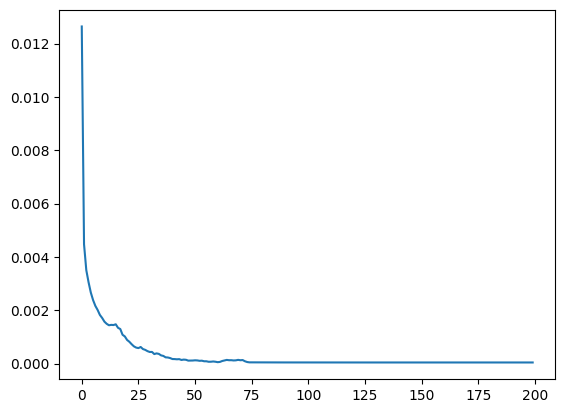

In [13]:
# eigenes Modell wird erstellt
model = MySimpleNN(input_size=784, hidden_size=(70,120,30),output_size=10)
lr=0.0001
# trainiere immer mit 10 Datensätzen auf einmal
batch_size=50

# loss function
# Mean Squared Error
# die Lossfunction von Pytorch müssen erstmal erstellt werden mit ()
loss_fn = nn.CrossEntropyLoss()
optemizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optemizer, mode='min', factor=0.1, patience=10, verbose=True, threshold=0.0001)

def train(xb, yb):
    y_hat=model(xb)
    loss = loss_fn(y_hat, yb)
    loss.backward()
    optemizer.step()
    return loss.item()

losses=[]
for epoch in range(200):
    loss_sum=0
    # Iteration über alle Batches
    for xb, yb in get_batch(x_train, y_train, batch_size):
        loss_sum += train(xb, yb)
    losses.append(loss_sum/len(x_train))
    scheduler.step(losses[-1])
#plot
import matplotlib.pyplot as plt
plt.plot(losses)

## Auswertung

In [ ]:
#calculate mean error
error_list=[]
for xb, yb in get_batch(x_test, y_test, batch_size):
    y_hat=model(xb)
    for i in range(len(yb)):
        error_list.append(yb[i]-y_hat[i])

print("mean error:" , sum(error_list)/len(error_list))

print("mean absolute error:" , sum([abs(element) for element in error_list])/len(error_list))